# CSC413 Lab 7: Text Classification using RNNs

**Sentiment Analysis** is the problem of identifying the writer's sentiment given a piece of text.
Sentiment Analysis can be applied to movie reviews, feedback of other forms, emails, tweets,
course evaluations, and much more.

In this lab, we will build an RNN to classify positive vs negative tweets
We use the Sentiment140 data set, which contains tweets with either a positive
or negative emoticon. Our goal is to determine whether which type of
emoticon the tweet (with the emoticon removed) contained. The dataset was actually collected by
a group of students, much like you, who are doing their first machine learning projects.

By the end of this lab, you will be able to:

- Use PyTorch to train an RNN model
- Apply and analyze the components of an RNN model
- Explain how batching is done on sequence data, where the training data in a batch may have different lengths
- Use pre-trained word embeddings as part of a transfer learning strategy for text classification
- Understand the bias that exists in word embeddings and language models.

Acknowledgements:

- Data is sampled from http://help.sentiment140.com/for-students


Please work in groups of 1-2 during the lab.

## Submission

If you are working with a partner, start by creating a group on Markus. If you are working alone,
click "Working Alone".

Submit the ipynb file `lab10.ipynb` on Markus
**containing all your solutions to the Graded Task**s.
Your notebook file must contain your code **and outputs** where applicable,
including printed lines and images.
Your TA will not run your code for the purpose of grading.

For this lab, you should submit the following:

- Part 1. Your output showing several positive tweets. (1 point)
- Part 2. Your implementation of the RNN. (5 point)
- Part 2. Your explanation of the shapes of `wordemb`. (1 point)
- Part 2. Your explanation of the shapes of `h` and `out`. (2 points)
- Part 3. Your demonstration of the model's ability to "overfit" on a data set. (1 point)
- Part 3. Your output from training the model on the full data set. (1 point)
- Part 3. Your comparison of using a different architecture from before. (2 points)
- Part 4. Your implementation of `MyGloveRnn`. (2 points)
- Part 4. Your explanation of why `MyGloveRNN` requires fewer iteration to obtain "good" accuracy. (1 point)
- Part 4. Your comparison of `MyGloveRNN` and `MyRNN` in low data settings. (1 point)
- Part 4. Your explanation of where the biases in embeddings come from, and whether our model will have the same sorts of biases. (1 point)
- Part 5. Your reflection on the sentiment analysis task. (2 points)


## Part 1. Data

Start by running these two lines of code to download the data on to Google Colab.

In [ ]:
# Download tutorial data files.
!wget https://www.cs.toronto.edu/~lczhang/413/sample_tweets.csv

--2024-03-31 19:38:57--  https://www.cs.toronto.edu/~lczhang/413/sample_tweets.csv
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11099815 (11M) [text/csv]
Saving to: ‘sample_tweets.csv.1’

sample_tweets.csv.1 100%[===================>]  10.58M  11.0MB/s    in 1.0s    

2024-03-31 19:38:58 (11.0 MB/s) - ‘sample_tweets.csv.1’ saved [11099815/11099815]



As always, we start by understanding what our data looks like. Notice that the
test set has been set aside for us. Both the training and test set files follow
the same format. Each line in the csv file contains the tweet text,
the string label "4" (positive) or "0" (negative), and some additional information about the tweet.

In [ ]:
import csv
datafile = "sample_tweets.csv"

# Training/Validation set
data = csv.reader(open(datafile))
for i, line in enumerate(data):
    print(line)
    if i > 10:
        break

['0', '1467810672', 'Mon Apr 06 22:19:49 PDT 2009', 'NO_QUERY', 'scotthamilton', "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"]
['0', '1467812025', 'Mon Apr 06 22:20:09 PDT 2009', 'NO_QUERY', 'mimismo', '@twittera que me muera ? ']
['0', '1467812723', 'Mon Apr 06 22:20:19 PDT 2009', 'NO_QUERY', 'TLeC', "@caregiving I couldn't bear to watch it.  And I thought the UA loss was embarrassing . . . . ."]
['0', '1467813782', 'Mon Apr 06 22:20:34 PDT 2009', 'NO_QUERY', 'gi_gi_bee', '@FakerPattyPattz Oh dear. Were you drinking out of the forgotten table drinks? ']
['0', '1467818481', 'Mon Apr 06 22:21:46 PDT 2009', 'NO_QUERY', 'lionslamb', "He's the reason for the teardrops on my guitar the only one who has enough of me to break my heart "]
['0', '1467824967', 'Mon Apr 06 22:23:28 PDT 2009', 'NO_QUERY', 'playboybacon', "Mo jobs, no money.  how in the hell is min wage here 4 f'n clams an hour?"]
['0', '1467835305', 'Mon Apr 06 2

**Task**: How many positive and negative tweets are in this file?

In [ ]:
from collections import Counter
# There are 39694 negatives and 40197 positives, so the data is not skewed.
print(Counter(x[0] for x in csv.reader(open(datafile))))

Counter({'4': 40197, '0': 39694})


**Graded Task**: We have printed several negative tweets above.
Print 10 positive tweets.

In [ ]:
# Output:
# ['4', '1467822272', 'Mon Apr 06 22:22:45 PDT 2009', 'NO_QUERY', 'ersle', 'I LOVE @Health4UandPets u guys r the best!! ']
# ['4', '1467822814', 'Mon Apr 06 22:22:54 PDT 2009', 'NO_QUERY', 'misstoriblack', 'Just added tweetie to my new iPhone ']
# ['4', '1467822936', 'Mon Apr 06 22:22:57 PDT 2009', 'NO_QUERY', 'adamjackson', "Catching Up on Emails, RSS and Random BACN. Then I'm cutting out early tonight (11:30PM) to have Dinner with @lauraw "]
# ['4', '1467823405', 'Mon Apr 06 22:23:03 PDT 2009', 'NO_QUERY', 'gattermeier', 'reaching amritsar in an hour and (if i find a bus) should be at wagah border by 2pm  - http://bkite.com/06fuJ']
# ['4', '1467823919', 'Mon Apr 06 22:23:10 PDT 2009', 'NO_QUERY', 'loveshine', 'YAY! found a new cuddle buddy ']
# ['4', '1467841923', 'Mon Apr 06 22:27:57 PDT 2009', 'NO_QUERY', 'AishaNH', "@JonathanRKnight hmm you have a lot to say tonight! That's great!  Of course, here I am up late reading it. haha"]
# ['4', '1467842136', 'Mon Apr 06 22:28:01 PDT 2009', 'NO_QUERY', 'Jamie_Cheroske', "@enbaldarlingg No, that's just the mirror you're looking in. "]
# ['4', '1467843554', 'Mon Apr 06 22:28:23 PDT 2009', 'NO_QUERY', 'SerendipityMuse', 'amazing night with llama and malcolm and megan&lt;---fuck the theatre! ']
# ['4', '1467844198', 'Mon Apr 06 22:28:33 PDT 2009', 'NO_QUERY', 'Lavanyaj', '@procoder hmmm, sure sure  so what r u upto ? hows the day for u?']
# ['4', '1467844679', 'Mon Apr 06 22:28:41 PDT 2009', 'NO_QUERY', 'BackSassMaster', '@ijustine http://twitpic.com/1ff65 - I love ur top ']
# ['4', '1467861230', 'Mon Apr 06 22:32:55 PDT 2009', 'NO_QUERY', 'jailynpr', "@ben_mayer better be. I don't wanna have to come find u and save the dog. But I would!  I'm all 4 the animals . Call off the twit police"]
data = csv.reader(open(datafile))
i = 0
for line in data:
    if line[0] == '4':
      print(line)
      i += 1
    if i > 10:
        break


['4', '1467822272', 'Mon Apr 06 22:22:45 PDT 2009', 'NO_QUERY', 'ersle', 'I LOVE @Health4UandPets u guys r the best!! ']
['4', '1467822814', 'Mon Apr 06 22:22:54 PDT 2009', 'NO_QUERY', 'misstoriblack', 'Just added tweetie to my new iPhone ']
['4', '1467822936', 'Mon Apr 06 22:22:57 PDT 2009', 'NO_QUERY', 'adamjackson', "Catching Up on Emails, RSS and Random BACN. Then I'm cutting out early tonight (11:30PM) to have Dinner with @lauraw "]
['4', '1467823405', 'Mon Apr 06 22:23:03 PDT 2009', 'NO_QUERY', 'gattermeier', 'reaching amritsar in an hour and (if i find a bus) should be at wagah border by 2pm  - http://bkite.com/06fuJ']
['4', '1467823919', 'Mon Apr 06 22:23:10 PDT 2009', 'NO_QUERY', 'loveshine', 'YAY! found a new cuddle buddy ']
['4', '1467841923', 'Mon Apr 06 22:27:57 PDT 2009', 'NO_QUERY', 'AishaNH', "@JonathanRKnight hmm you have a lot to say tonight! That's great!  Of course, here I am up late reading it. haha"]
['4', '1467842136', 'Mon Apr 06 22:28:01 PDT 2009', 'NO_QUERY', 

We will now split the dataset into training, validation, and test sets:

In [ ]:
# read the data; convert labels into integers
data = [(review, int(label=='4'))  # label 1 = positive, 0 = negative
        for label, _, _, _, _, review in csv.reader(open(datafile))]

# shuffle the data, since the file stores all negative tweets first
import random
random.seed(42)
random.shuffle(data)

train_data = data[:50000]
val_data = data[50000:60000]
test_data = data[60000:]

In order to be able to use neural networks to make predictions about these tweets,
we need to begin by convert these tweets into sequences of numbers, each representing
a words. This is akin to a one-hot encoding: each word will be converted into an
a number representing the unique *index* of that word.

Although we could do this conversion by writing our own python code,
torch has a package called **torchtext** that has utilities useful for text classification
and generation tasks.
In particular, the `Vocab` class and `build_vocab_from_iterator` will be useful for us
for building the mapping from words to indices.

In [ ]:
import torchtext

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab, build_vocab_from_iterator

# we will *tokenize* each word by using a tokenzier from
# https://pytorch.org/text/stable/data_utils.html#get-tokenizer

tokenizer = get_tokenizer("basic_english")
train_data_words = [tokenizer(x) for x, t in train_data]

# build the vocabulary object. the parameters to this function
# is described below
vocab = build_vocab_from_iterator(train_data_words,
                                  specials=['<bos>', '<eos>', '<unk>', '<pad>'],
                                  min_freq=10)

# set the index of a word not in the vocabulary
vocab.set_default_index(2) # this is the index of the `<unk>` keyword

Now, `vocab` is an object of class `Vocab` (see more here [https://pytorch.org/text/stable/vocab.html](https://pytorch.org/text/stable/vocab.html) )
that provides functionalities for converting words into their indices.
In addition to words appearing in the training set, ther are four special tokens that
we use, akin to placeholder words:

- `<bos>`, to indicate the beginning of a sequence.
- `<eos>`, to indicate the end of a sequence.
- `<unk>`, to indicate a word that is *not* in the vocabulary. This includes
  words that appear too infrequently to be included in the vocabulary, and any
  other words in the validation/test sets that are not see in training.
- `<pad>`, used for padding shorter sequences in a batch: since each tweet
  may have different length, the shorter tweets in each batch will be padded with
  the `<pad>` token so that each sequence (tweet) in a batch has the same length.

The `min_freq` parameter identifies the minimum number of times a word must appear in the
training set in order to be included in the vocabulary.

Here you can see the `vocab` object in action:

In [ ]:
# Print the number of words in the vocabulary
print(len(vocab))

# Convert a tweet into a sequence of word indices.
tweet = 'The movie Pneumonoultramicroscopicsilicovolcanoconiosis is a good movie, it is very funny'
tokens = tokenizer(f'<bos> {tweet} <eos>')
print(tokens)
indices = vocab.forward(tokens)
print(indices)

4117
['<bos>', 'the', 'movie', 'pneumonoultramicroscopicsilicovolcanoconiosis', 'is', 'a', 'good', 'movie', ',', 'it', 'is', 'very', 'funny', '<eos>']
[0, 9, 257, 2, 17, 11, 39, 257, 10, 15, 17, 137, 363, 1]


**Task**: What is the index of the `<pad>` token?

In [ ]:
# The pad token is at index 3.
print(vocab.forward(['<pad>']))

[3]


Now let's apply this transformation to the entire set of training, validation, and test data.

In [ ]:

def convert_indices(data, vocab):
    """Convert data of form [(tweet, label)...] where tweet is a string
    into an equivalent list, but where the tweets represented as a list
    of word indices.
    """
    return [(vocab.forward(tokenizer(f'<bos> {text} <eos>')), label)
            for (text, label) in data]

train_data_indices = convert_indices(train_data, vocab)
val_data_indices = convert_indices(val_data, vocab)
test_data_indices = convert_indices(test_data, vocab)

We have seen that PyTorch's `DataLoader` provides an easy way to form minibatches
when we worked with image data. However, text and sequence data is more challenging to
work with since the sequences may not be the same length.

Although we can (and will!) continue to use `DataLoader` for our text data, we need to
provide a function that merges sequences of various lengths into two PyTorch tensors
correspondingg to the inputs and targets for that batch.


**Task**: Following the instructions below, complete the `collate_batch` function,
which creates the input and target tensors
for a batch of data.

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    """
    Returns the input and target tensors for a batch of data

    Parameters:
        `batch` - An iterable data structure of tuples (indices, label),
                  where `indices` is a sequence of word indices, and
                  `label` is either 1 or 0.

    Returns: a tuple `(X, t)`, where
        - `X` is a PyTorch tensor of shape (batch_size, sequence_length)
        - `t` is a PyTorch tensor of shape (batch_size)
    where `sequence_length` is the length of the longest sequence in the batch
    """

    text_list = []  # collect each sample's sequence of word indices
    label_list = [] # collect each sample's target labels
    for (text_indices, label) in batch:
        text_list.append(torch.tensor(text_indices))
        label_list.append(torch.tensor(label))

    X = pad_sequence(text_list, padding_value=3).transpose(0, 1)
    t = torch.tensor(label_list)
    return X, t


train_dataloader = DataLoader(train_data_indices, batch_size=10, shuffle=True,
                              collate_fn=collate_batch)

With the above code in mind, we should be able to extract batches from `train_dataloader`.
Notice that `X.shape` is different in each batch.
You should also see that the index `3` is used to pad shorter sequences in in a batch.

In [ ]:
for i, (X, t) in enumerate(train_dataloader):
    print(X.shape, t.shape)
    if i >= 10:
        break

print(X)

torch.Size([10, 39]) torch.Size([10])
torch.Size([10, 35]) torch.Size([10])
torch.Size([10, 33]) torch.Size([10])
torch.Size([10, 34]) torch.Size([10])
torch.Size([10, 37]) torch.Size([10])
torch.Size([10, 36]) torch.Size([10])
torch.Size([10, 36]) torch.Size([10])
torch.Size([10, 40]) torch.Size([10])
torch.Size([10, 35]) torch.Size([10])
torch.Size([10, 33]) torch.Size([10])
torch.Size([10, 33]) torch.Size([10])
tensor([[   0,    2,  958,    9, 1643,   64,    9, 2312,    4,    1,    3,    3,
            3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
            3,    3,    3,    3,    3,    3,    3,    3,    3],
        [   0,    2,    9,    2,   64,   12, 2199,  256,    9,  643,   27,    5,
           37, 3038,    9,  408, 1778,   31,   95,    2,    1,    3,    3,    3,
            3,    3,    3,    3,    3,    3,    3,    3,    3],
        [   0,    2,    5,   85,    8,  605,   13,   11, 2218,   29,    5,  107,
           13,    8,  247,   25,    1,    3,    3

**Task**: Why does each sequence begin with the token `0`, and end with the token `1` (ignoring
the paddings).

In [ ]:
# The token 0 is associated with the beginning token <bos> and 1 with the end
# token <eos>, both of which are added before vocab is applied.

## Part 2. Model

We will use a recurrent neural network model to classify positive vs negative
sentiments. Our RNN model will have three components that are typical in a
sequence classification model:

- An *embedding layer*, which will map each word index (akin to a one-hot embedding)
  into a low-dimensional vector. This layer as having the same functionality as the
  weights $W^{(word)}$ from lab 2.
- A *recurrent layer*, which performs the recurrent neural network computation.
  The input to this layer is the low-dimensional embedding vectors
  for each word in the sequence.
- A *fully connected layer*, which computes the final binary classification using
  features computed from the recurrent layer. Think about how you can combine the per-timestep
  output of the RNN into one final prediction.

Let's define the model that we will use, and then explore it step by step.

**Graded Task**: Implement the forward pass of the model and the RNN component.

In [ ]:
import torch.nn as nn
# Note: we added an extra implementation to myRNN so that we can change the
# architecture to bidirectional and stacked later
class MyRNN(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, num_classes,
                 bidirectional = 0, num_layers = 1):
        super(MyRNN, self).__init__()
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.emb = nn.Embedding(vocab_size, emb_size)

        self.rnn = nn.RNN(emb_size, hidden_size, batch_first=True, bidirectional=(bidirectional==1),num_layers=num_layers)
        self.mlp = nn.Linear((1+bidirectional)*hidden_size, num_classes)

    def forward(self, X):
        X = self.emb(X)
        X, h = self.rnn(X)
        X = self.mlp(X)
        X = torch.mean(X,1)
        return X

model = MyRNN(len(vocab), 128, 64, 2)

To explore exactly what this model is doing, let's grab one batch of data from
the data loader we created. We will observe, step-by-step, what computation will be
performed on the input `X` to obtain the final prediction. We do this by
emulating the `forward` method of the `MyRNN` function.

In [ ]:
X, t = next(iter(train_dataloader))

print(X.shape, t.shape)
print(X)
print(t)

torch.Size([10, 27]) torch.Size([10])
tensor([[   0,  438,    8,  817,   99,   63,   31,    9,    2,   29,  116,    8,
          110,  368,   14,  257, 1008, 1524,  303,    9,    2,    4,    5,  110,
           12,  371,    1],
        [   0,    2,   11,   39,  246,    4,  691,    9,   91,  451,    1,    3,
            3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
            3,    3,    3],
        [   0,  695,   18,    2,   70,  107,    2,    1,    3,    3,    3,    3,
            3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
            3,    3,    3],
        [   0,    2,  121,  176,   13,    4,    1,    3,    3,    3,    3,    3,
            3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
            3,    3,    3],
        [   0,   49,  215,    4,    2,  344,    6,  826,   36,  236,   25,   70,
          816,    4,    1,    3,    3,    3,    3,    3,    3,    3,    3,    3,
            3,    3,    3],
        [   

**Graded Task**: Run the code below to check the shape of `wordemb`.
What shape does this tensor have?  Explain what each dimension in this shape means.

In [ ]:
wordemb = model.emb(X)

print(wordemb.shape)

# The shape of word emb is (10,26,128), while the shape of X is (10,26). The
# extra dimensions come from taking each of the 26 word indices in the 10
# sequences and converting them into their 1x128 embedded representation, so
# for each element in 10x26 X, there is an element in 10x26x128 wordemb.

torch.Size([10, 27, 128])


**Graded Task**: Run the code below, which computes the RNN forward pass,
with `wordemb` as input.
What shape do the tensors `h` and `out` have?  Explain what these tensors correspond to.
(See the RNN reference [https://pytorch.org/docs/stable/generated/torch.nn.RNN.html](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) on the PyTorch documentation page.)

In [ ]:
# If you get a problem here, rename your recurrent unit ;)
h, out = model.rnn(wordemb)

print(h.shape)
print(out.shape)

# The tensors `h` and `out` are related. To see the relation,
# choose an index in the batch and compare the following two
# vectors in `h` and `out`.
index = 2 # choose an index to iterate through the batch
print(h[index, -1, :])
print(out[0, index, :])

# h has shape (10,26,64), so it corresponds to passing each 26x128 onehot
# sequence of words through a hidden layer of size 64, which reproduces
# the same number of output hidden states with size 64, so we get a sequence
# of dimensions (26,64). Since there are 10 of these, we get the shape. The
# value of out is just the particular hidden state output at the end of the
# recurrence, so we can ignore it.

torch.Size([10, 27, 64])
torch.Size([1, 10, 64])
tensor([ 0.5184,  0.2389,  0.9657, -0.6450, -0.3981,  0.8351, -0.5623,  0.9597,
        -0.0735, -0.3929,  0.8070,  0.9667,  0.6458, -0.5475, -0.8397, -0.9470,
        -0.7239, -0.9253,  0.7657, -0.5859,  0.6369, -0.5955, -0.0463, -0.4170,
        -0.7493, -0.4544,  0.3118, -0.8470, -0.5177,  0.7767, -0.7380, -0.8391,
        -0.2035, -0.6746,  0.7673, -0.9955, -0.1918,  0.1915, -0.2832,  0.2964,
        -0.8101, -0.1179, -0.7270,  0.4134,  0.9396,  0.4715,  0.2467, -0.9216,
        -0.6645,  0.7512, -0.4909,  0.7433,  0.2844,  0.3199,  0.9596,  0.6385,
        -0.5752, -0.9428,  0.6810,  0.0755,  0.8428,  0.0335,  0.1695,  0.9799],
       grad_fn=<SliceBackward0>)
tensor([ 0.5184,  0.2389,  0.9657, -0.6450, -0.3981,  0.8351, -0.5623,  0.9597,
        -0.0735, -0.3929,  0.8070,  0.9667,  0.6458, -0.5475, -0.8397, -0.9470,
        -0.7239, -0.9253,  0.7657, -0.5859,  0.6369, -0.5955, -0.0463, -0.4170,
        -0.7493, -0.4544,  0.3118, -0

There is one more thing we need to do before training the model, which is
to write a function to estimate the accuracy of the model. This is done for
you below.

In [ ]:
# if you get a problem here, check how you implemented the output of your model
def accuracy(model, dataset, max=1000):
    """
    Estimate the accuracy of `model` over the `dataset`.
    We will take the **most probable class**
    as the class predicted by the model.

    Parameters:
        `model`   - An object of class nn.Module
        `dataset` - A dataset of the same type as `train_data`.
        `max`     - The max number of samples to use to estimate
                    model accuracy

    Returns: a floating-point value between 0 and 1.
    """

    correct, total = 0, 0
    dataloader = DataLoader(dataset,
                            batch_size=1,  # use batch size 1 to prevent padding
                            collate_fn=collate_batch)
    for i, (x, t) in enumerate(dataloader):
        z = model(x)
        y = torch.argmax(z, axis=1)
        correct += int(torch.sum(t == y))
        total   += 1
        if i >= max:
            break
    return correct / total

accuracy(model, val_data_indices) # should be close to half (0.51)

0.4775224775224775

## Part 3. Training

In this section, we will train the `MyRNN` model to classify tweets.
As the models that we are building begin to increase in complexity, it is important
to use good debugging techniques. In this section, we will introduce the technique of
checking whether the model and training code is able to overfit on a small training set.
This is a way to check for bugs in the implementation.

**Task**: Complete the training code below

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

def train_model(model,                # an instance of MLPModel
                train_data,           # training data
                val_data,             # validation data
                learning_rate=0.001,
                batch_size=100,
                num_epochs=10,
                plot_every=50,        # how often (in # iterations) to track metrics
                plot=True):           # whether to plot the training curve
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               collate_fn=collate_batch,
                                               shuffle=True) # reshuffle minibatches every epoch
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # these lists will be used to track the training progress
    # and to plot the training curve
    iters, train_loss, train_acc, val_acc = [], [], [], []
    iter_count = 0 # count the number of iterations that has passed

    try:
        for e in range(num_epochs):
            for i, (texts, labels) in enumerate(train_loader):
                z = model(texts)
                onehot = nn.functional.one_hot(labels.long(), model.num_classes).type(torch.float)

                loss = criterion(z, onehot)

                loss.backward() # propagate the gradients
                optimizer.step() # update the parameters
                optimizer.zero_grad() # clean up accumualted gradients

                iter_count += 1
                if iter_count % plot_every == 0:
                    iters.append(iter_count)
                    ta = accuracy(model, train_data)
                    va = accuracy(model, val_data)
                    train_loss.append(float(loss))
                    train_acc.append(ta)
                    val_acc.append(va)
                    print(iter_count, "Loss:", float(loss), "Train Acc:", ta, "Val Acc:", va)
    finally:
        # This try/finally block is to display the training curve
        # even if training is interrupted
        if plot:
            plt.figure()
            plt.plot(iters[:len(train_loss)], train_loss)
            plt.title("Loss over iterations")
            plt.xlabel("Iterations")
            plt.ylabel("Loss")

            plt.figure()
            plt.plot(iters[:len(train_acc)], train_acc)
            plt.plot(iters[:len(val_acc)], val_acc)
            plt.title("Accuracy over iterations")
            plt.xlabel("Iterations")
            plt.ylabel("Loss")
            plt.legend(["Train", "Validation"])

**Graded Task**: As a way to check the model and training code,
check if your model can obtain a 100\% training accuracy relatively quickly
(e.g. within less than a minute of training time), when training on only the
first 20 element of the training data.

10 Loss: 0.8084011673927307 Train Acc: 0.7 Val Acc: 0.5154845154845155
20 Loss: 0.4938964247703552 Train Acc: 1.0 Val Acc: 0.5674325674325674
30 Loss: 0.4189926087856293 Train Acc: 0.85 Val Acc: 0.5464535464535465
40 Loss: 0.8098344802856445 Train Acc: 0.85 Val Acc: 0.5354645354645354
50 Loss: 0.29451984167099 Train Acc: 1.0 Val Acc: 0.5604395604395604
60 Loss: 0.2856394946575165 Train Acc: 1.0 Val Acc: 0.5724275724275725
70 Loss: 0.10585257411003113 Train Acc: 1.0 Val Acc: 0.5744255744255744
80 Loss: 0.13279934227466583 Train Acc: 1.0 Val Acc: 0.5744255744255744
90 Loss: 0.04345269501209259 Train Acc: 1.0 Val Acc: 0.5804195804195804
100 Loss: 0.03996763378381729 Train Acc: 1.0 Val Acc: 0.5614385614385614
110 Loss: 0.014045439660549164 Train Acc: 1.0 Val Acc: 0.5744255744255744
120 Loss: 0.010781136341392994 Train Acc: 1.0 Val Acc: 0.5714285714285714
130 Loss: 0.014283089898526669 Train Acc: 1.0 Val Acc: 0.5714285714285714
140 Loss: 0.01424113567918539 Train Acc: 1.0 Val Acc: 0.5714285

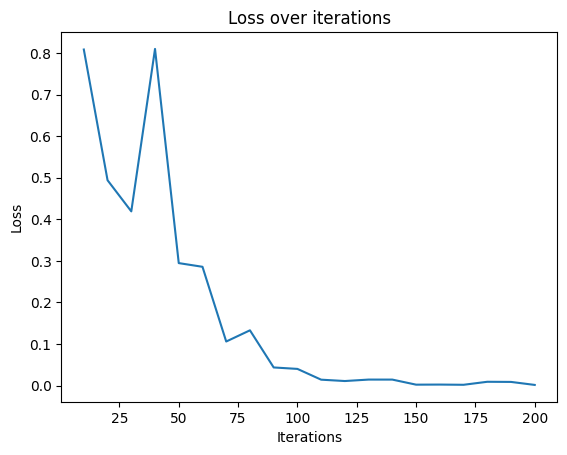

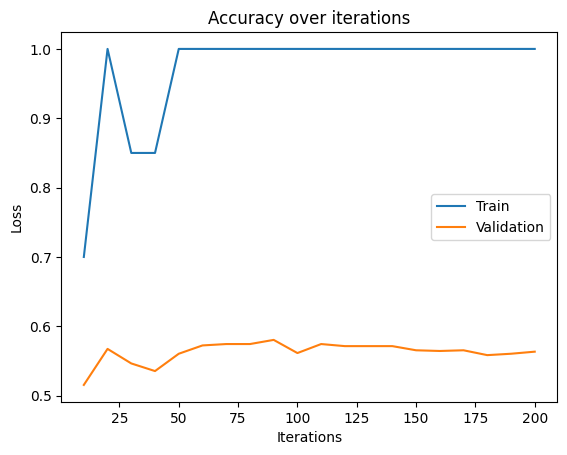

In [ ]:
model = MyRNN(vocab_size=len(vocab),
              emb_size=300,
              hidden_size=64,
              num_classes=2)
train_model(model, train_data_indices[:20], val_data_indices, batch_size=1,plot_every=10)
# Output: (we reach 100% training accuracy in less than 30 seconds)
# 10 Loss: 0.6742010712623596 Train Acc: 0.7 Val Acc: 0.5394605394605395
# 20 Loss: 0.7172380685806274 Train Acc: 0.9 Val Acc: 0.5634365634365635
# 30 Loss: 0.5317018032073975 Train Acc: 0.8 Val Acc: 0.5414585414585414
# 40 Loss: 0.8312522172927856 Train Acc: 0.85 Val Acc: 0.5384615384615384
# 50 Loss: 0.4994592070579529 Train Acc: 1.0 Val Acc: 0.5684315684315684
# 60 Loss: 0.34602105617523193 Train Acc: 1.0 Val Acc: 0.5824175824175825
# 70 Loss: 0.17761339247226715 Train Acc: 1.0 Val Acc: 0.5694305694305695
# 80 Loss: 0.2111210823059082 Train Acc: 1.0 Val Acc: 0.5664335664335665
# 90 Loss: 0.030459614470601082 Train Acc: 1.0 Val Acc: 0.5724275724275725
# 100 Loss: 0.0254337377846241 Train Acc: 1.0 Val Acc: 0.5674325674325674
# 110 Loss: 0.0076130968518555164 Train Acc: 1.0 Val Acc: 0.5594405594405595
# 120 Loss: 0.01889796182513237 Train Acc: 1.0 Val Acc: 0.5544455544455544
# 130 Loss: 0.009990568272769451 Train Acc: 1.0 Val Acc: 0.5464535464535465
# 140 Loss: 0.008865046314895153 Train Acc: 1.0 Val Acc: 0.5424575424575424
# 150 Loss: 0.007985925301909447 Train Acc: 1.0 Val Acc: 0.5434565434565435
# 160 Loss: 0.0037694370839744806 Train Acc: 1.0 Val Acc: 0.5484515484515484
# 170 Loss: 0.0038936531636863947 Train Acc: 1.0 Val Acc: 0.5504495504495505
# 180 Loss: 0.010187767446041107 Train Acc: 1.0 Val Acc: 0.5494505494505495
# 190 Loss: 0.007170655764639378 Train Acc: 1.0 Val Acc: 0.5464535464535465
# 200 Loss: 0.002184030832722783 Train Acc: 1.0 Val Acc: 0.5414585414585414

**Task**: Will this model that you trained above have a high accuracy over
the validation set? Explain why or why not.

In [ ]:
# The model should not have a high validation accuracy as we train on a very
# small constrained set of examples, which means it is very unlikely to
# generalize well to unknown data. If we expose it to the rest of the training
# set, it is likely to improve much better.

**Graded Task**: Train your model on the full data set. What validation accuracy
can you achieve? (Our implementation achieved just shy of 80% without much tuning of HPs, can you match this?)

50 Loss: 0.6698580980300903 Train Acc: 0.6333666333666333 Val Acc: 0.6193806193806194
100 Loss: 0.6589363217353821 Train Acc: 0.6743256743256744 Val Acc: 0.6343656343656343
150 Loss: 0.5967096090316772 Train Acc: 0.7002997002997003 Val Acc: 0.6843156843156843
200 Loss: 0.6190652251243591 Train Acc: 0.7302697302697303 Val Acc: 0.7002997002997003
250 Loss: 0.5693690776824951 Train Acc: 0.7482517482517482 Val Acc: 0.7002997002997003
300 Loss: 0.6224051117897034 Train Acc: 0.7392607392607392 Val Acc: 0.7082917082917083
350 Loss: 0.4829910695552826 Train Acc: 0.7572427572427572 Val Acc: 0.7242757242757243
400 Loss: 0.6311174631118774 Train Acc: 0.7762237762237763 Val Acc: 0.7232767232767233
450 Loss: 0.5861951112747192 Train Acc: 0.7802197802197802 Val Acc: 0.7402597402597403
500 Loss: 0.5559953451156616 Train Acc: 0.7812187812187812 Val Acc: 0.7392607392607392
550 Loss: 0.7040927410125732 Train Acc: 0.7762237762237763 Val Acc: 0.7492507492507493
600 Loss: 0.6037006378173828 Train Acc: 0.78

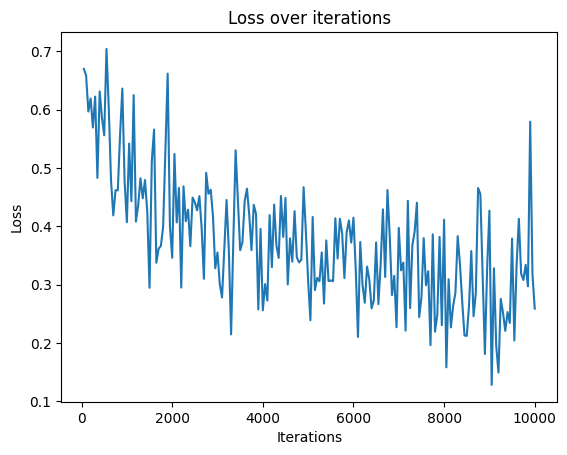

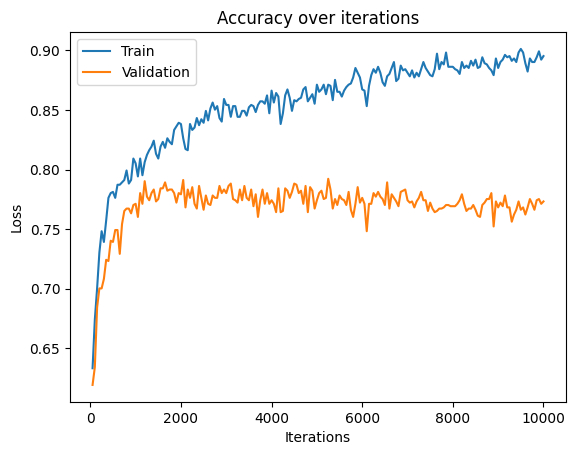

In [ ]:
model = MyRNN(vocab_size=len(vocab),
              emb_size=500,
              hidden_size=64,
              num_classes=2)
train_model(model, train_data_indices, val_data_indices, batch_size=50,plot_every=50)
# We kept everything the same and increased the hidden layer's size so the amount
# of information that the RNN hidden outputs carry is much higher. For most of
# the training, the validation reached near 80% and just started oscillating
# right below it, while the training was increasing up to right above 90%. Due
# to time constraints, we cannot explore this for more parameters.

**Graded task:** There are several different variants of RNN architectures. Chose a *different one* from the one you used previously and reimplement the model and the training loop below. It is OK to copy/paste the majority of the code. Make sure you have train and eval loss as before. Compare the final validation accuracy and comment on whether you obtained the expected results. Why/why not?

50 Loss: 0.685637891292572 Train Acc: 0.6323676323676324 Val Acc: 0.6253746253746254
100 Loss: 0.6471484303474426 Train Acc: 0.6493506493506493 Val Acc: 0.6503496503496503
150 Loss: 0.6575396656990051 Train Acc: 0.7052947052947053 Val Acc: 0.6813186813186813
200 Loss: 0.5991405248641968 Train Acc: 0.7112887112887113 Val Acc: 0.6923076923076923
250 Loss: 0.6355879306793213 Train Acc: 0.7222777222777222 Val Acc: 0.7082917082917083
300 Loss: 0.6288484930992126 Train Acc: 0.7042957042957043 Val Acc: 0.7092907092907093
350 Loss: 0.6091251373291016 Train Acc: 0.7242757242757243 Val Acc: 0.7302697302697303
400 Loss: 0.4728010594844818 Train Acc: 0.7372627372627373 Val Acc: 0.7172827172827173
450 Loss: 0.5510717630386353 Train Acc: 0.7202797202797203 Val Acc: 0.7012987012987013
500 Loss: 0.420139878988266 Train Acc: 0.7652347652347652 Val Acc: 0.7452547452547452
550 Loss: 0.5074965357780457 Train Acc: 0.7812187812187812 Val Acc: 0.7472527472527473
600 Loss: 0.5084739923477173 Train Acc: 0.7702

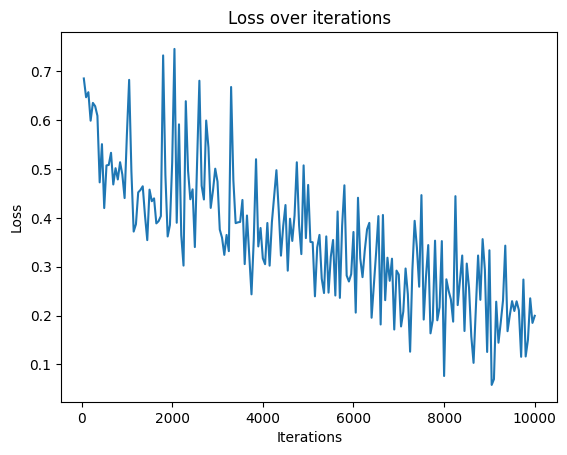

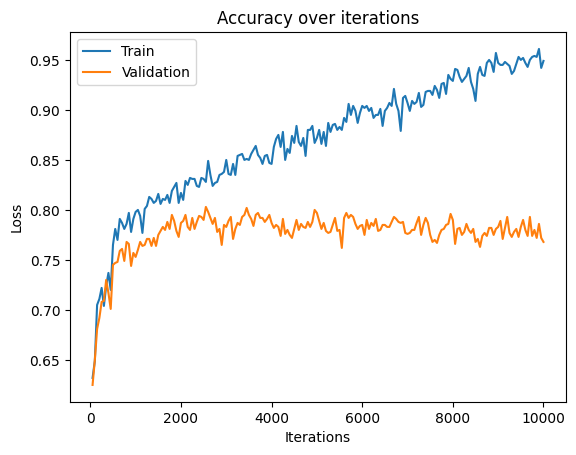

In [ ]:
# We will implement a stacked RNN with bidirectionality, using the same class
# but with the hidden variables bidirectional=1 and num_layers=2.
model = MyRNN(vocab_size=len(vocab),
              emb_size=300,
              hidden_size=64,
              num_classes=2,
              bidirectional=1,
              num_layers=2)
train_model(model, train_data_indices, val_data_indices, batch_size=50, plot_every=50)
# Comparing the final accuracies, it seems that the validation accuracy stayed
# the same while the training accuracy went slightly higher, so the additional
# degrees of freedom did not prevent the same overfitting problem, and just
# increased the amount by which it overfit on training. This result is to be
# expected as we did not change the architecture significantly, as a bi-RNN
# with extra layers only really increases the memory we have access to for each
# individual word, but since we use all the hidden states, it does not really
# matter.

## Part 4. Pretrained Embeddings

As we saw in the previous lab on images, **transfer learning** is a useful technique
in practical machine learning, especially in low-data settings:
instead of training an entire neural network from scratch, we use (part of) a
model that is pretrained on large amounts of similar data. We use the intermediate
state of this pretrained model as features to our model---i.e. we use the pretrained
models to compute *features*.

Just like with images, using a pretrained model is an important strategy for working
with text. Large language models is an excellent demonstration of how generalizable
pretrained features can be.

In this part of the lab, we will use a slightly older idea of using pretrained *word embeddings*.
In particular, instead of training our own `nn.Embedding` layer, we will use
GloVe embeddings (2014) [https://nlp.stanford.edu/projects/glove/](https://nlp.stanford.edu/projects/glove/)
trained on a large data set containing all of Wikipedia and other webpages.

Nowadays, large language model (LLMs), including those with APIs provided by various organizations,
can also be used to map words/sentences into embeddings.
However, the basic idea of using pretrained models in low-data settings remains similar.
We will also identify some bias issues with pretrained word embeddings.
There is evidence that these types of bias issues
continues to persist in LLMs as well.

In [ ]:
from torchtext.vocab import GloVe

glove = torchtext.vocab.GloVe(name="6B", dim=300)

**Task**: Run the below code to print the GloVe word embedding for the word "cat".

In [ ]:
print(glove['cat'])

tensor([-0.2935,  0.3325, -0.0474, -0.1225,  0.0720, -0.2341, -0.0624, -0.0037,
        -0.3946, -0.6941,  0.3673, -0.1214, -0.0445, -0.1527,  0.3486,  0.2293,
         0.5436,  0.2521,  0.0980, -0.0873,  0.8706, -0.1221, -0.0798,  0.2871,
        -0.6856, -0.2727,  0.2206, -0.7575,  0.5629,  0.0914, -0.7100, -0.3142,
        -0.5683, -0.2668, -0.6010,  0.2696, -0.1799,  0.1070, -0.5786,  0.3816,
        -0.6713,  0.1093,  0.0794,  0.0224, -0.0811,  0.0112,  0.6709, -0.1909,
        -0.3368, -0.4847, -0.3541, -0.1521,  0.4450,  0.4638,  0.3841,  0.0451,
        -0.5908,  0.2176,  0.3858, -0.4457,  0.0093,  0.4420,  0.0971,  0.3801,
        -0.1188, -0.4272, -0.3101, -0.0251,  0.1269, -0.1347,  0.1198,  0.7625,
         0.2524, -0.2693,  0.0686, -0.1007,  0.0111, -0.1853,  0.4498, -0.5751,
         0.1228, -0.0649,  0.0445, -0.0210, -0.0698, -0.4733, -0.4307,  0.3916,
        -0.0478, -0.9366, -0.5513, -0.1422, -0.1583,  0.1562,  0.0705,  0.1989,
         0.1894, -0.1934, -0.4659, -0.02

Unfortunately, it is not straightforward to add the `<pad>`, `<unk>`, `<bos>` and `<eos>`
tokens. So we will do without them.

**Task**: Run the below code to look up GloVe word indices for the training, validation, and
test sets.

In [ ]:
def convert_indices_glove(data, default=len(glove)-1):
    result = []
    for text, label in data:
        words = tokenizer(text) # for simplicity, we wont use <bos> and <eos>
        indices = []
        for w in words:
            if w in glove.stoi:
                indices.append(glove.stoi[w])
            else:
                # this is a bit of a hack, but we will repurpose *last* word
                # (least common word) appearing in the GloVe vocabluary as our
                # '<pad>' token
                indices.append(default)
        result.append((indices, label),)
    return result

train_data_glove = convert_indices_glove(train_data)
val_data_glove = convert_indices_glove(val_data)
test_data_glove = convert_indices_glove(test_data)

**Graded task**: Now, we will modify the `MyRNN` to use the pretrained GloVe vectors. Make sure to not update the glove embeddings. You can reuse code from above.

In [ ]:
class MyGloveRNN(nn.Module):
    def __init__(self,  hidden_size, num_classes):
        super(MyGloveRNN, self).__init__()
        self.vocab_size, self.emb_size = glove.vectors.shape
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.emb = nn.Embedding.from_pretrained(glove.vectors.type(torch.float), freeze=True)
        self.rnn = nn.RNN(self.emb_size, hidden_size, batch_first = True)
        self.mlp = nn.Linear(hidden_size, num_classes)

    def forward(self, X):
        Y = self.emb(X)
        Y, h = self.rnn(Y)
        Y = self.mlp(Y)
        Y = torch.mean(Y, 1)
        return Y

model = MyGloveRNN(64, 2)

**Task** Train this model. Use comparable hyperparameters so that you can compare
your result against `MyRNN`.

50 Loss: 0.6646877527236938 Train Acc: 0.6333666333666333 Val Acc: 0.6103896103896104
100 Loss: 0.668062150478363 Train Acc: 0.6703296703296703 Val Acc: 0.6323676323676324
150 Loss: 0.6150889992713928 Train Acc: 0.7002997002997003 Val Acc: 0.6863136863136863
200 Loss: 0.5462754964828491 Train Acc: 0.6943056943056943 Val Acc: 0.6873126873126874
250 Loss: 0.6815383434295654 Train Acc: 0.7072927072927073 Val Acc: 0.6993006993006993
300 Loss: 0.6047294735908508 Train Acc: 0.7162837162837162 Val Acc: 0.7032967032967034
350 Loss: 0.684566855430603 Train Acc: 0.7192807192807192 Val Acc: 0.7062937062937062
400 Loss: 0.7426096200942993 Train Acc: 0.7132867132867133 Val Acc: 0.7212787212787213
450 Loss: 0.5953515768051147 Train Acc: 0.7112887112887113 Val Acc: 0.7062937062937062
500 Loss: 0.5980176329612732 Train Acc: 0.7242757242757243 Val Acc: 0.7152847152847153
550 Loss: 0.5678830146789551 Train Acc: 0.6983016983016983 Val Acc: 0.7112887112887113
600 Loss: 0.5947128534317017 Train Acc: 0.7252

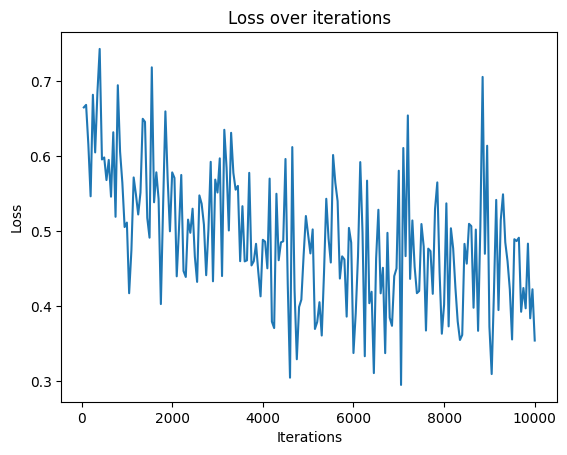

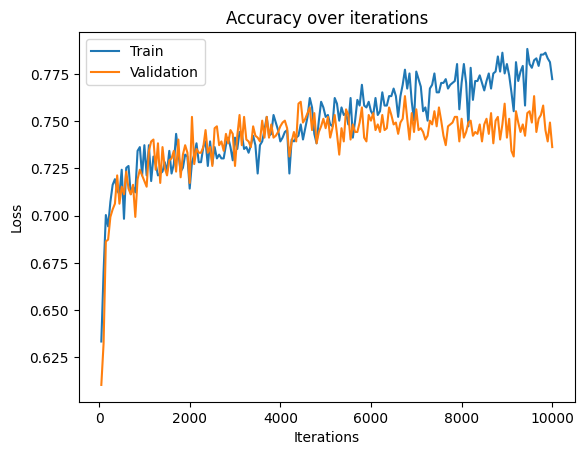

In [ ]:
train_model(model, train_data_glove, val_data_glove, batch_size=50,plot_every=50)

**Graded Task**: You might notice that a *very* smaller number of
iterations will be required to train this model to a reasonable
performance (e.g. >70% validation accuracy). Why might this be?

In [ ]:
# The weights of the embedding are pretrained to a good representation via GloVe
# which means that it is easier for the model to reach a better performance
# earlier in the training, as the gradients only have to adjust for the other
# weights, as shown by our example, which reaches 70% by the 4th plotted point.
# This however reduces its improvement later, as it has less expressiveness due
# to not as many weights being adjusted, and so cannot fit as well in the long
# run since we do not add the embedding as something to optimize. The final
# training accuracy is much lower at around 80% hence. However, note the curves
# of the validation and training accuracies are much closely matched, which is
# an effect of less overfitting.

**Graded Task**: Train both MyGloveRNN and MyRNN models using the corresponding
embeddings (pretrained vs. not), **but only with the first 200 data points in the
training set**. How do the validation accuracies compare between these two models?

50 Loss: 0.4045505225658417 Train Acc: 0.58 Val Acc: 0.5164835164835165
100 Loss: 0.42357227206230164 Train Acc: 0.655 Val Acc: 0.5694305694305695
150 Loss: 0.9975955486297607 Train Acc: 0.66 Val Acc: 0.5754245754245755
200 Loss: 0.4650125801563263 Train Acc: 0.655 Val Acc: 0.5764235764235764
250 Loss: 0.36537766456604004 Train Acc: 0.665 Val Acc: 0.5664335664335665
300 Loss: 0.6023018956184387 Train Acc: 0.735 Val Acc: 0.6113886113886113
350 Loss: 0.3656086027622223 Train Acc: 0.68 Val Acc: 0.6183816183816184
400 Loss: 0.1728377789258957 Train Acc: 0.66 Val Acc: 0.5674325674325674
450 Loss: 1.3547589778900146 Train Acc: 0.695 Val Acc: 0.5914085914085914
500 Loss: 0.5078925490379333 Train Acc: 0.785 Val Acc: 0.6513486513486514
550 Loss: 0.24513264000415802 Train Acc: 0.825 Val Acc: 0.6263736263736264
600 Loss: 0.5073331594467163 Train Acc: 0.805 Val Acc: 0.6443556443556444
650 Loss: 0.5117596983909607 Train Acc: 0.79 Val Acc: 0.6443556443556444
700 Loss: 1.8490710258483887 Train Acc: 0

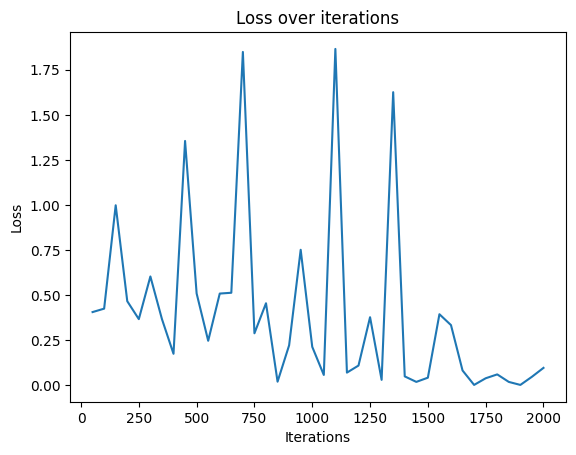

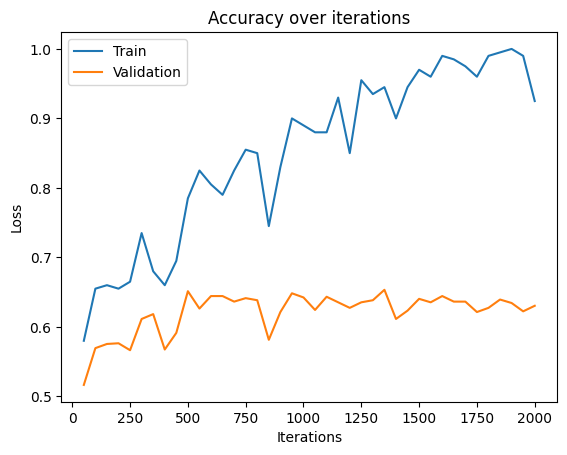

In [ ]:
model = MyGloveRNN(64, 2)
train_model(model, train_data_glove[0:200], val_data_glove, batch_size=1, plot_every=50, num_epochs=10)

50 Loss: 0.7242597341537476 Train Acc: 0.62 Val Acc: 0.5354645354645354
100 Loss: 0.4485866129398346 Train Acc: 0.72 Val Acc: 0.5504495504495505
150 Loss: 0.7534965872764587 Train Acc: 0.77 Val Acc: 0.5764235764235764
200 Loss: 0.6936112642288208 Train Acc: 0.79 Val Acc: 0.5834165834165834
250 Loss: 0.6646131873130798 Train Acc: 0.785 Val Acc: 0.5714285714285714
300 Loss: 0.27802157402038574 Train Acc: 0.835 Val Acc: 0.5844155844155844
350 Loss: 1.2053859233856201 Train Acc: 0.855 Val Acc: 0.6023976023976024
400 Loss: 1.0286188125610352 Train Acc: 0.875 Val Acc: 0.6013986013986014
450 Loss: 0.0963558778166771 Train Acc: 0.89 Val Acc: 0.6123876123876124
500 Loss: 0.0967789739370346 Train Acc: 0.915 Val Acc: 0.5824175824175825
550 Loss: 0.06283850967884064 Train Acc: 0.94 Val Acc: 0.6003996003996004
600 Loss: 0.0836004689335823 Train Acc: 0.97 Val Acc: 0.6123876123876124
650 Loss: 0.6309802532196045 Train Acc: 0.98 Val Acc: 0.6073926073926074
700 Loss: 0.10278189182281494 Train Acc: 0.99

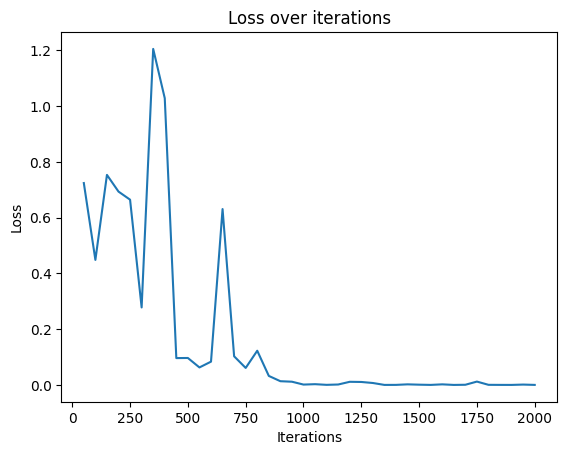

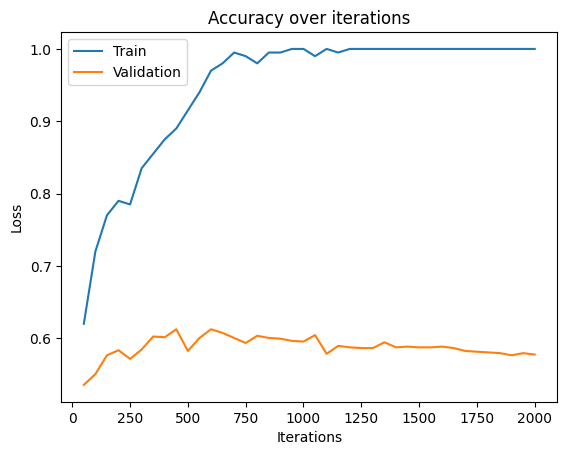

In [ ]:
model2 = MyRNN(vocab_size=len(vocab),
              emb_size=300,
              hidden_size=64,
              num_classes=2)
train_model(model2, train_data_indices[:200],val_data_indices, batch_size=1, plot_every=50, num_epochs=10)

In [ ]:
# Used a batch_size of 1 since it acted weirdly for higher batch sizes, given
# the small training data. We see the loss does not decrease by that much in
# the GLove model, and the training acc reaches 100% slower. The loss decreases
# faster for the normal RNN, and the training accuracy jumps much higher. The
# validation accuracy is lower than the GloVe model's though, which means
# that the GloVe model gets better generalization and does not overfit.

Machine learning models have an air of "fairness" about them, since models
make decisions without human intervention. However, models can and do learn
whatever bias is present in the training data.
GloVe vectors seems innocuous enough: they are just representations of
words in some embedding space. Even so, we will show that the structure
of the GloVe vectors encodes the everyday biases present in the texts
that they are trained on.

We start with an example analogy to demonstrate the power of GloVe embeddings
that allows us to complete analogies by applying arithmetic operations
to the word vectors.

$$doctor - man + woman \approx ??$$

To find the answers to the above analogy, we will compute the following vector,
and then find the word whose vector representation is *closest* to it.

In [ ]:
v = glove['doctor'] - glove['man'] + glove['woman']

**Task**: Run the code below to find the closets word. You should see the word
"nurse" fairly high up in that list.

In [ ]:
def print_closest_words(vec, n=5):
    dists = torch.norm(glove.vectors - vec, dim=1)     # compute distances to all words
    lst = sorted(enumerate(dists.numpy()), key=lambda x: x[1]) # sort by distance
    for idx, difference in lst[1:n+1]: 					       # take the top n
        print(glove.itos[idx], difference)

print_closest_words(v)

physician 6.7226787
nurse 6.7791734
woman 6.8218
doctors 6.963807
dentist 7.3165383


**Task**:  To compare, use a similar method to find the answer to this analogy:
$$doctor - woman + man \approx ??$$

In other words, we go the opposite direction in the "gender" axis to check
if similarly concerning analogies exist.

In [ ]:
print_closest_words(glove['doctor'] - glove['woman'] + glove['man'])

man 6.614642
physician 6.8267035
he 7.064041
mr. 7.065585
dr. 7.127458


**Task**: Compare the following two outputs.

In [ ]:
print_closest_words(glove['programmer'] - glove['man'] + glove['woman'])

programmers 6.906153
oly-2004-fhockey 7.1117373
http://www.nwguild.org 7.271939
bb94 7.282604
homemaker 7.296883


In [ ]:
print_closest_words(glove['programmer'] - glove['woman'] + glove['man'])

programmers 6.8631363
_____________________________________________ 7.49171
timewrn 7.4950824
jahch 7.561946
jihb 7.5969725


**Task**: Compare the following two outputs.

In [ ]:
print_closest_words(glove['professor'] - glove['man'] + glove['woman'])

lecturer 6.5699987
sociology 6.942095
university 6.985767
graduate 7.2252293
researcher 7.289195


In [ ]:
print_closest_words(glove['professor'] - glove['woman'] + glove['man'])

university 7.084462
prof. 7.0947814
emeritus 7.146991
harvard 7.289809
sociology 7.330031


**Task**: Compare the following two outputs.

In [ ]:
print_closest_words(glove['engineer'] - glove['man'] + glove['woman'])

technician 6.738221
engineers 7.143567
educator 7.160228
worker 7.294498
woman 7.3743315


In [ ]:
print_closest_words(glove['engineer'] - glove['woman'] + glove['man'])

engineers 7.340744
mechanic 7.6183243
engineering 7.689247
worked 7.8743134
technician 7.9948106


**Graded Task**: Explain where the bias in these embeddings come from.
Would you expect our word embeddings (trained on tweets) to be similarly
problematic? Why or why not?

In [ ]:
# The words that are more commonly used with women in text end up being associated
# more with being a woman, and likewise being a man. For example, if the text
# trained on contains instances of professor being associated with 'man' and
# 'tenure' and the like, the embedding will associate it more with being a man.
# Likewise, many instances of 'lecturer' and 'woman' together will cause the
# association of lecturers with women.

## Questioning your data's assumptions

**Graded Task:** The task we attempted in this lab is "sentiment analysis". However, the "sentiment" of a short text snippet such as a tweet can be hard to estimate. Give at least 2 reasons for why sentiment analysis can be difficult. Consider the data itself, the labelling task, and the model training. This is an open ended task, so we will grade you not on giving the most correct response, but for making a (very) short but succinct argument for problems you can think of.

In [ ]:
# Sentiments are very context-dependent, for example, the meaning of a statement
# in English changes based on where and when it is used. Because of this, the
# decision of what emotion it conveys is not always clear-cut and may not be
# fully given in the sentence itself, but also the events that surround it. As
# a case, saying "How are you" could be a regular daily greeting, or something
# you would say to a close friend going through a hard time. Even when the
# context is fully contained in the sentence, a good analysis of sentiment has
# to somehow compare and relate the words from one point to all the others,
# which means retention of information while reading the whole sentence. Thus,
# RNN's are not the best performers of sentiment analysis, as they can only
# maintain local information.

# Another reason why sentiments are difficult to figure out is because they tend
# to be complicated by the nuances of how language can be used. The additions of
# gestures and vocal variation in speech makes it possible to distinguish
# more meanings such as sarcasm and the like, while those are removed when
# using text, so in the absence of human processing, it can be hard to identify
# the tone in which something is written.